# Dockerized ML API — Model Development Notebook

**Author:** Mike Ichikawa  
**Date:** January 2026

This notebook walks through the model development process for the anomaly detection ensemble:
exploring synthetic sensor data, comparing detector behaviors, and evaluating the ensemble.
The final model is serialized and served via FastAPI.

In [1]:
import sys
sys.path.insert(0, '..')

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, f1_score
from sklearn.decomposition import PCA

from model.train import generate_data, ensemble_predict, N_FEATURES

plt.rcParams.update({'figure.facecolor': 'white', 'axes.grid': True, 'grid.alpha': 0.3})
print(f'N_FEATURES = {N_FEATURES}')

N_FEATURES = 8


## 1. Synthetic Data Exploration

We generate 10,000 observations: 9,500 normal sensor readings and 500 anomalies (5% contamination).
Three types of anomalies are injected: extreme spikes, correlation breaks, and cluster drift.

Total samples: 10,000
Normal: 9,500 (95.0%)
Anomaly: 500 (5.0%)
Feature shape: (10000, 8)


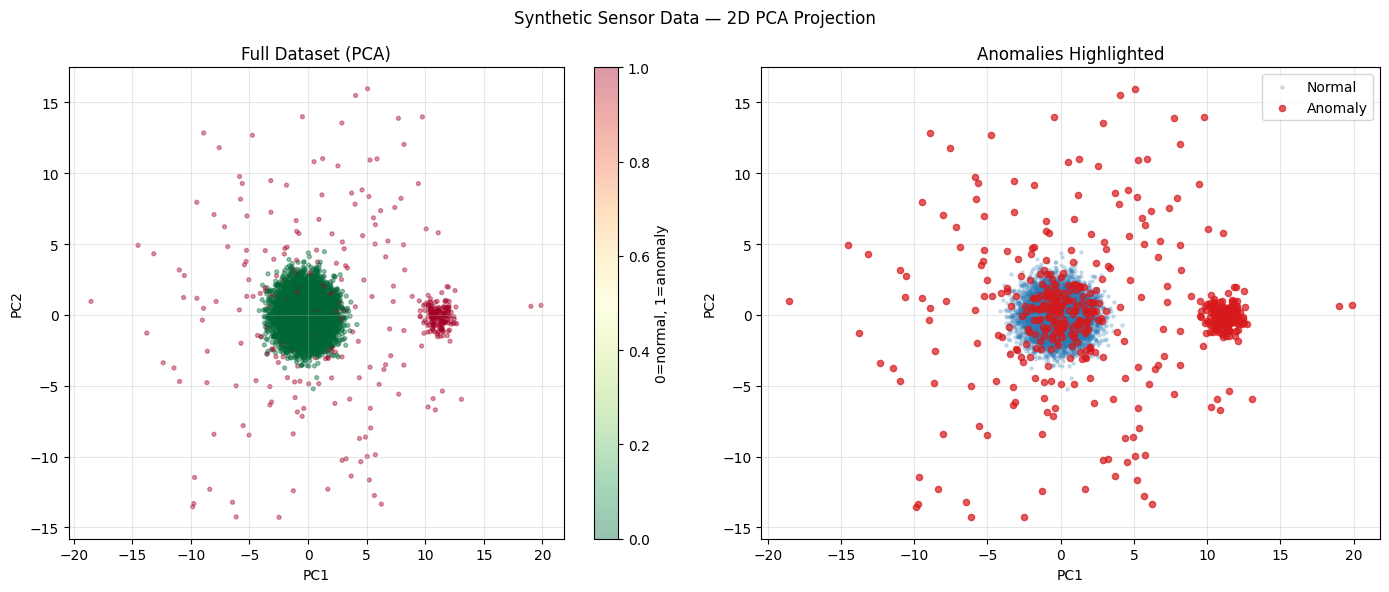

Explained variance ratio: PC1=0.286, PC2=0.144


In [2]:
X, y = generate_data(n_samples=10000, contamination=0.05)

print(f'Total samples: {len(X):,}')
print(f'Normal: {(y==0).sum():,} ({(y==0).mean():.1%})')
print(f'Anomaly: {(y==1).sum():,} ({(y==1).mean():.1%})')
print(f'Feature shape: {X.shape}')

# PCA to visualize 8D data in 2D
pca = PCA(n_components=2)
X_2d = pca.fit_transform(X)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle('Synthetic Sensor Data — 2D PCA Projection')

# All data
ax = axes[0]
scatter = ax.scatter(X_2d[:, 0], X_2d[:, 1], c=y, cmap='RdYlGn_r',
                     alpha=0.4, s=8)
plt.colorbar(scatter, ax=ax, label='0=normal, 1=anomaly')
ax.set_title('Full Dataset (PCA)')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')

# Zoom to anomalies only
ax = axes[1]
ax.scatter(X_2d[y==0, 0], X_2d[y==0, 1], c='#2C7BB6', alpha=0.2, s=5, label='Normal')
ax.scatter(X_2d[y==1, 0], X_2d[y==1, 1], c='#D7191C', alpha=0.7, s=20, label='Anomaly', zorder=5)
ax.set_title('Anomalies Highlighted')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.legend()

plt.tight_layout()
plt.savefig('../model/artifacts/nb_data_pca.png', dpi=120, bbox_inches='tight')
plt.show()

print(f'Explained variance ratio: PC1={pca.explained_variance_ratio_[0]:.3f}, PC2={pca.explained_variance_ratio_[1]:.3f}')

## 2. Individual Detector Comparison

Let's see how each detector performs independently before combining them.

In [3]:
X_train, X_test = X[:8000], X[8000:]
y_train, y_test = y[:8000], y[8000:]

# Train detectors
iforest = IsolationForest(n_estimators=200, contamination=0.05, random_state=42, n_jobs=-1)
iforest.fit(X_train)

lof = LocalOutlierFactor(n_neighbors=20, contamination=0.05, novelty=True, n_jobs=-1)
lof.fit(X_train)

scaler = StandardScaler().fit(X_train)

# Individual predictions
if_pred  = (iforest.predict(X_test) == -1).astype(int)
lof_pred = (lof.predict(X_test) == -1).astype(int)
z_pred   = (np.abs(scaler.transform(X_test)).max(axis=1) > 3.0).astype(int)
ens_pred = ((if_pred + lof_pred + z_pred) >= 2).astype(int)

print('Individual Detector Performance:')
print('='*60)
for name, pred in [('Isolation Forest', if_pred), ('LOF', lof_pred),
                    ('Z-score', z_pred), ('Ensemble (≥2 votes)', ens_pred)]:
    f1 = f1_score(y_test, pred)
    report = classification_report(y_test, pred, target_names=['normal','anomaly'],
                                   output_dict=True)
    p = report['anomaly']['precision']
    r = report['anomaly']['recall']
    print(f'{name:<25} F1={f1:.3f}  Prec={p:.3f}  Recall={r:.3f}')

Individual Detector Performance:
Isolation Forest          F1=0.761  Prec=0.722  Recall=0.806
LOF                       F1=0.593  Prec=0.566  Recall=0.621
Z-score                   F1=0.938  Prec=1.000  Recall=0.883
Ensemble (≥2 votes)       F1=0.863  Prec=0.843  Recall=0.883


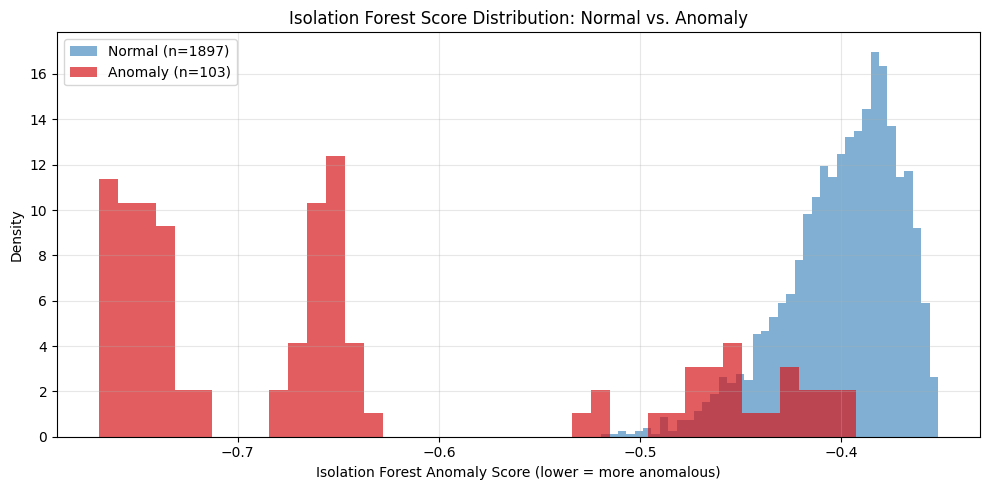

Normal mean score:  -0.3997 ± 0.0286
Anomaly mean score: -0.6444 ± 0.1203
Separation (Cohen d): 2.80


In [4]:
# Score distributions: anomaly vs normal
if_scores_normal  = iforest.score_samples(X_test[y_test==0])
if_scores_anomaly = iforest.score_samples(X_test[y_test==1])

fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(if_scores_normal, bins=40, alpha=0.6, color='#2C7BB6',
        label=f'Normal (n={len(if_scores_normal)})', density=True)
ax.hist(if_scores_anomaly, bins=40, alpha=0.7, color='#D7191C',
        label=f'Anomaly (n={len(if_scores_anomaly)})', density=True)
ax.set_xlabel('Isolation Forest Anomaly Score (lower = more anomalous)')
ax.set_ylabel('Density')
ax.set_title('Isolation Forest Score Distribution: Normal vs. Anomaly')
ax.legend()
plt.tight_layout()
plt.savefig('../model/artifacts/nb_score_dist.png', dpi=120, bbox_inches='tight')
plt.show()

print(f'Normal mean score:  {if_scores_normal.mean():.4f} ± {if_scores_normal.std():.4f}')
print(f'Anomaly mean score: {if_scores_anomaly.mean():.4f} ± {if_scores_anomaly.std():.4f}')
print(f'Separation (Cohen d): {abs(if_scores_normal.mean() - if_scores_anomaly.mean()) / np.sqrt((if_scores_normal.std()**2 + if_scores_anomaly.std()**2)/2):.2f}')

## 3. Z-score Threshold Sensitivity

The Z-score detector has one tunable parameter: threshold. Let's find the optimal value.

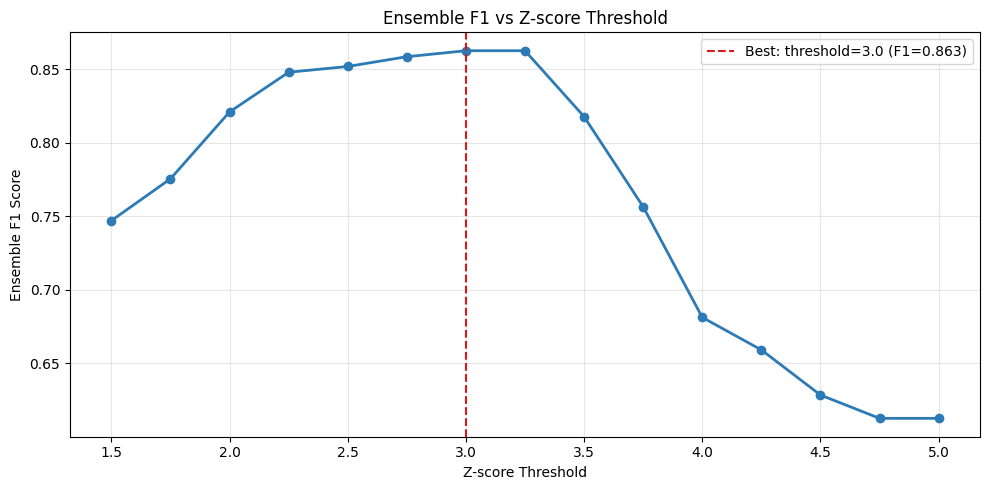

Best Z-score threshold: 3.0 → F1 = 0.8626


In [5]:
models = {'isolation_forest': iforest, 'lof': lof, 'scaler': scaler}

thresholds = np.arange(1.5, 5.1, 0.25)
f1_scores = []

for t in thresholds:
    pred = ensemble_predict(models, X_test, z_threshold=t)
    f1_scores.append(f1_score(y_test, pred, zero_division=0))

best_idx = np.argmax(f1_scores)
best_t = thresholds[best_idx]
best_f1 = f1_scores[best_idx]

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(thresholds, f1_scores, 'o-', color='#2C7BB6', linewidth=2)
ax.axvline(best_t, color='#D7191C', linestyle='--', label=f'Best: threshold={best_t} (F1={best_f1:.3f})')
ax.set_xlabel('Z-score Threshold')
ax.set_ylabel('Ensemble F1 Score')
ax.set_title('Ensemble F1 vs Z-score Threshold')
ax.legend()
plt.tight_layout()
plt.savefig('../model/artifacts/nb_threshold_sweep.png', dpi=120, bbox_inches='tight')
plt.show()

print(f'Best Z-score threshold: {best_t} → F1 = {best_f1:.4f}')

## 4. Final Model — Train and Verify

Run the full training pipeline and verify the saved model loads correctly.

In [6]:
import subprocess
result = subprocess.run(['python', '../model/train.py'], capture_output=True, text=True)
print(result.stdout)
if result.returncode != 0:
    print('STDERR:', result.stderr)


✓ Model trained and saved.
  F1=0.863  Prec=0.843  Rec=0.883
  Path: /Users/michaelichikawa/code/github_project/projects-hub/dockerized-ml-api/notebooks/../model/artifacts/ensemble_model.joblib



In [7]:
# Verify the saved model works
from app.predictor import AnomalyPredictor

pred = AnomalyPredictor(model_path='../model/artifacts/ensemble_model.joblib')
print('Model loaded:', pred.is_loaded)

# Test normal observation
normal_result = pred.predict([0.1, 0.2, -0.1, 0.3, 0.0, 0.15, -0.05, 0.25])
print(f'\nNormal observation:')
print(f'  is_anomaly: {normal_result["is_anomaly"]}')
print(f'  confidence: {normal_result["confidence"]}')
print(f'  votes: {normal_result["votes"]}')

# Test anomalous observation
anomaly_result = pred.predict([8.5, -7.2, 9.1, -8.8, 7.6, -9.3, 8.2, -7.5])
print(f'\nAnomalous observation:')
print(f'  is_anomaly: {anomaly_result["is_anomaly"]}')
print(f'  confidence: {anomaly_result["confidence"]}')
print(f'  votes: {anomaly_result["votes"]}')

2026-02-20 12:06:42,774 [INFO] Model loaded: version=1.0.0, detectors=['isolation_forest', 'lof', 'scaler']


Model loaded: True

Normal observation:
  is_anomaly: False
  confidence: 1.0
  votes: {'isolation_forest': False, 'lof': False, 'zscore': False}

Anomalous observation:
  is_anomaly: True
  confidence: 1.0
  votes: {'isolation_forest': True, 'lof': True, 'zscore': True}
